In [3]:
!nvidia-smi

Tue Apr  1 13:06:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              3W /   69W |    4191MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%%time
import cudf
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Read in the datasets (assuming these are already loaded in your environment)
all_train = cudf.read_csv("all_train.csv")
all_test  = cudf.read_csv("all_test.csv")

# Combine the datasets
all_data = cudf.concat([all_train, all_test], ignore_index=True)

# Display head
all_data.head()

CPU times: user 8.4 s, sys: 2.82 s, total: 11.2 s
Wall time: 27.9 s


,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1.0,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,...,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0.0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,...,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


In [3]:
# Display basic info
all_data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10500000 entries, 0 to 10499999
Data columns (total 29 columns):
 #   Column   Dtype
---  ------   -----
 0   # label  float64
 1   f0       float64
 2   f1       float64
 3   f2       float64
 4   f3       float64
 5   f4       float64
 6   f5       float64
 7   f6       float64
 8   f7       float64
 9   f8       float64
 10  f9       float64
 11  f10      float64
 12  f11      float64
 13  f12      float64
 14  f13      float64
 15  f14      float64
 16  f15      float64
 17  f16      float64
 18  f17      float64
 19  f18      float64
 20  f19      float64
 21  f20      float64
 22  f21      float64
 23  f22      float64
 24  f23      float64
 25  f24      float64
 26  f25      float64
 27  f26      float64
 28  mass     float64
dtypes: float64(29)
memory usage: 2.3 GB


In [4]:
# Descriptive statistics
all_data.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,...,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07,1.050000e+07
mean,5.000120e-01,1.634200e-02,1.220000e-04,-7.200000e-05,1.094100e-02,-8.800000e-05,2.696000e-03,1.815800e-02,8.400000e-05,2.240000e-04,...,1.159200e-02,-3.570000e-04,6.700000e-05,1.810000e-04,1.228800e-02,9.587000e-03,5.649000e-03,-1.442000e-03,1.525800e-02,1.000121e+03
std,5.000000e-01,1.004651e+00,9.974010e-01,9.999420e-01,9.952600e-01,9.998410e-01,1.000696e+00,9.868290e-01,9.964660e-01,9.999770e-01,...,1.002700e+00,1.000255e+00,1.000118e+00,1.000106e+00,1.010020e+00,1.004886e+00,1.010658e+00,9.846360e-01,9.821310e-01,3.534667e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757863e+00,-1.732359e+00,...,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736820e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.654076e+00,5.000000e+02
25%,0.000000e+00,-7.286900e-01,-7.337040e-01,-8.658630e-01,-6.089270e-01,-8.657530e-01,-1.054221e+00,-7.567430e-01,-7.014660e-01,-8.658530e-01,...,-7.425870e-01,-7.212160e-01,-8.659830e-01,-5.736820e-01,-5.415250e-01,-5.114680e-01,-3.543820e-01,-6.924800e-01,-7.941670e-01,7.500000e+02
50%,1.000000e+00,-3.913000e-02,4.620000e-04,-2.550000e-04,1.993600e-02,-2.850000e-04,-5.984000e-03,-1.502700e-01,9.900000e-05,1.017000e-03,...,-9.003700e-02,-3.210000e-04,-1.540000e-04,-5.736820e-01,-1.602610e-01,-3.143720e-01,-3.265230e-01,-3.567210e-01,-8.862100e-02,1.000000e+03
75%,1.000000e+00,6.904900e-01,7.341870e-01,8.656560e-01,6.798440e-01,8.656380e-01,8.504880e-01,7.686950e-01,7.013120e-01,8.663220e-01,...,6.422150e-01,7.205710e-01,8.660170e-01,-5.736820e-01,4.811270e-01,1.629950e-01,-2.334880e-01,4.758880e-01,7.606430e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365296e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.933915e+00,2.758590e+00,1.731450e+00,...,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.326623e+00,9.357253e+00,1.555813e+01,5.277313e+00,4.613183e+00,1.500000e+03


In [6]:
# Checking NULL values
all_data.isnull().sum()

# label    0
f0         0
f1         0
f2         0
f3         0
f4         0
f5         0
f6         0
f7         0
f8         0
f9         0
f10        0
f11        0
f12        0
f13        0
f14        0
f15        0
f16        0
f17        0
f18        0
f19        0
f20        0
f21        0
f22        0
f23        0
f24        0
f25        0
f26        0
mass       0
dtype: int64

In [7]:
# Checking duplicate values
all_data.nunique()

# label          2
f0         1184053
f1         2637739
f2         2200791
f3         1456457
f4         2199797
f5              10
f6         1210616
f7         2722576
f8         2200406
f9               2
f10        1127265
f11        2694681
f12        2200546
f13              2
f14        1016286
f15        2654217
f16        2201346
f17              2
f18         915798
f19        2598487
f20        2199362
f21              2
f22        1237529
f23         647573
f24         430700
f25         933247
f26         964895
mass             5
dtype: int64

># Check for Class Imbalances

Class Counts:
 # label
1.0    5250124
0.0    5249876
Name: count, dtype: int64

Difference between class counts: 248


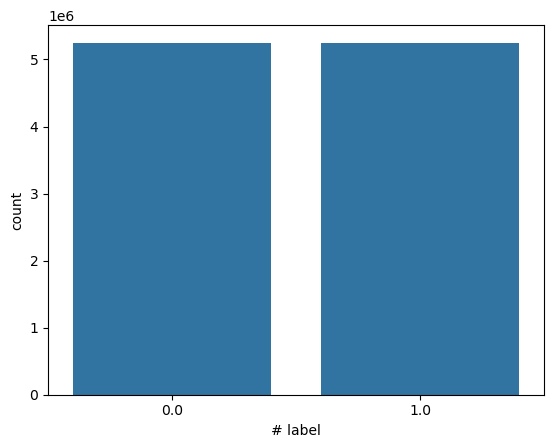

In [8]:

# Count occurrences of each class
class_counts = all_data["# label"].value_counts()
print("Class Counts:\n", class_counts)

# Calculate the difference
class_difference = abs(class_counts.iloc[0] - class_counts.iloc[1])
print("\nDifference between class counts:", class_difference)

# Convert cudf DataFrame to pandas for Seaborn visualization
all_data_pd = all_data.to_pandas()

# Plot the class distribution
sns.countplot(x="# label", data=all_data_pd)
plt.show()


># Bivariate Analysis between features

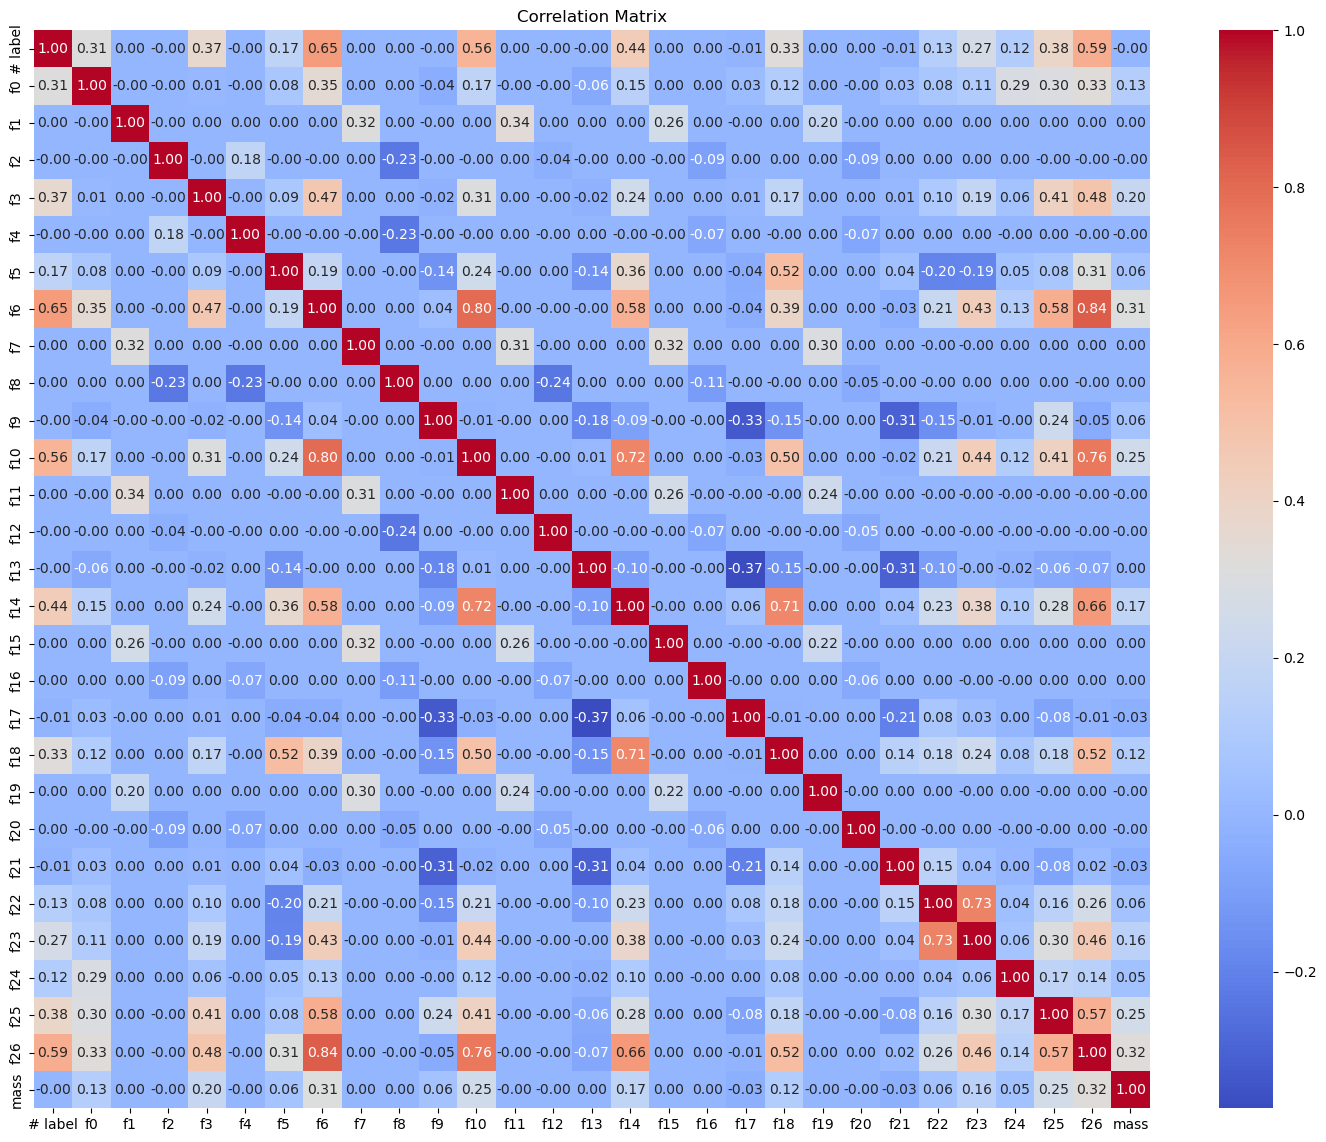

In [3]:
# Compute the correlation matrix
correlation_matrix = all_data.to_pandas().corr()

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


># Histograms

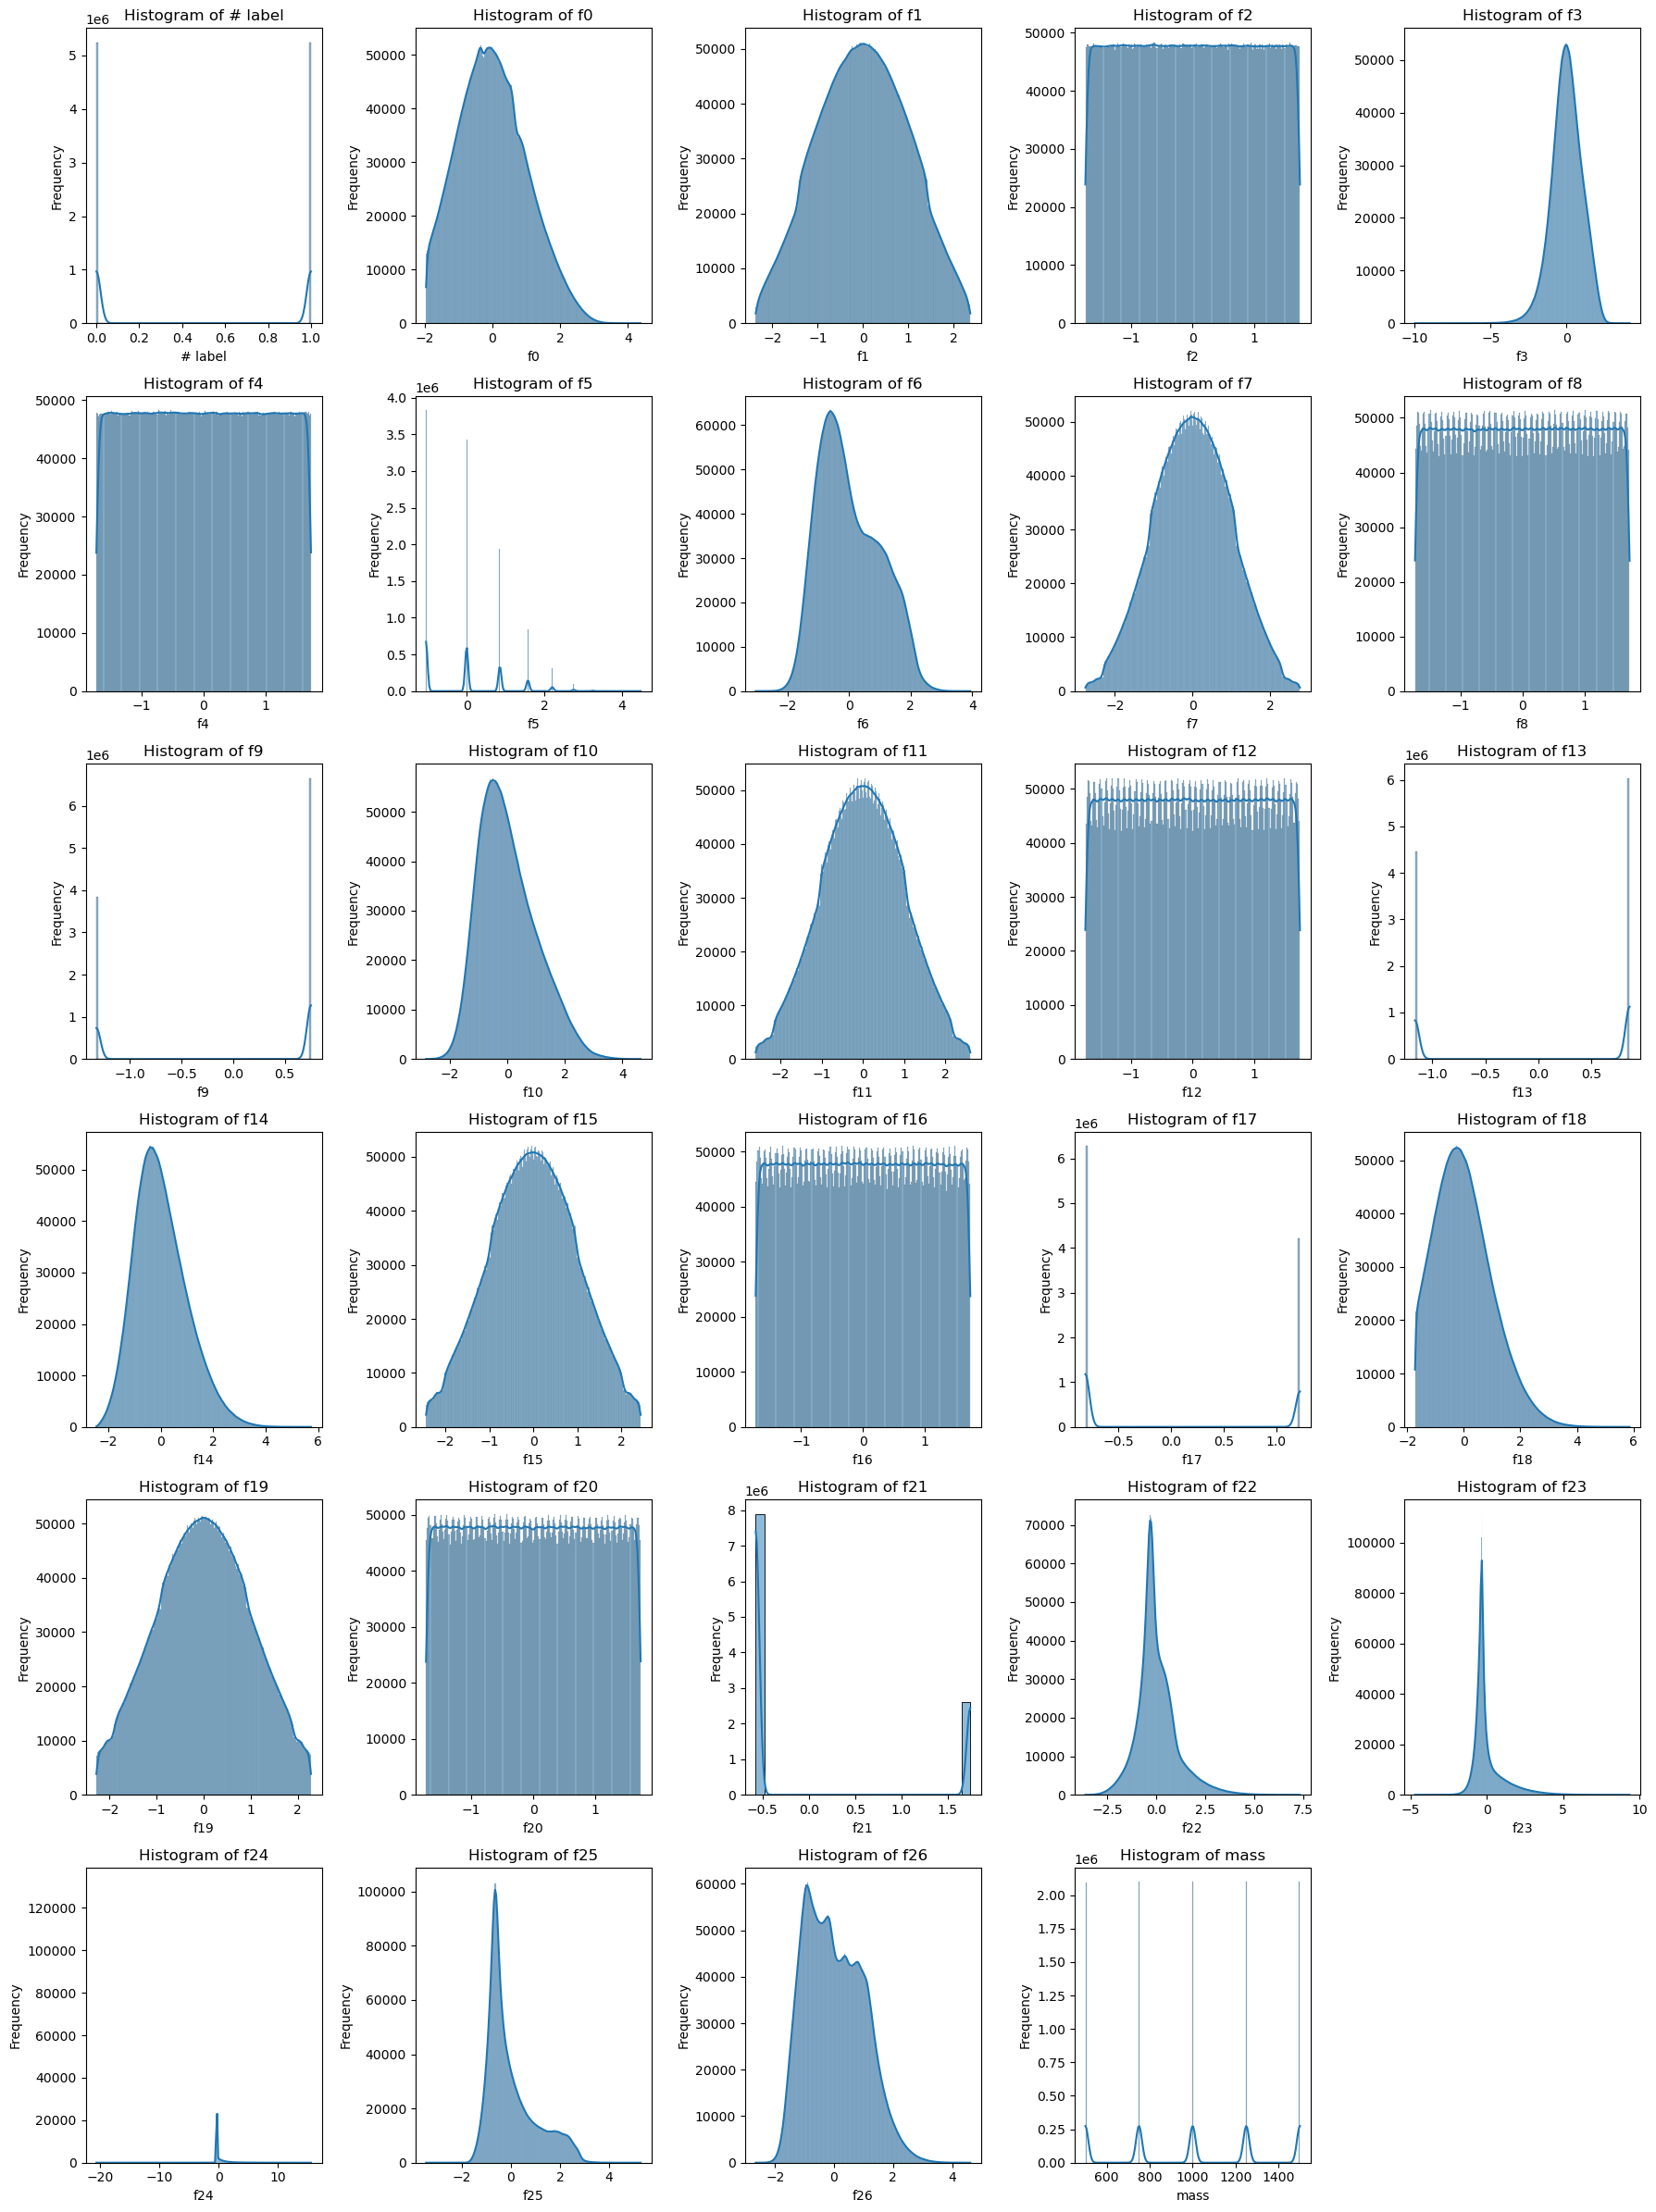

In [4]:
# Get the number of columns in the dataset
num_cols = len(all_data.columns)
cols_per_row = 5  # Set 5 plots per row
rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4 * rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Plot histograms
for i, column in enumerate(all_data.columns):
    sns.histplot(all_data[column].to_pandas(), kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


># Box Plots for Outlier Analysis

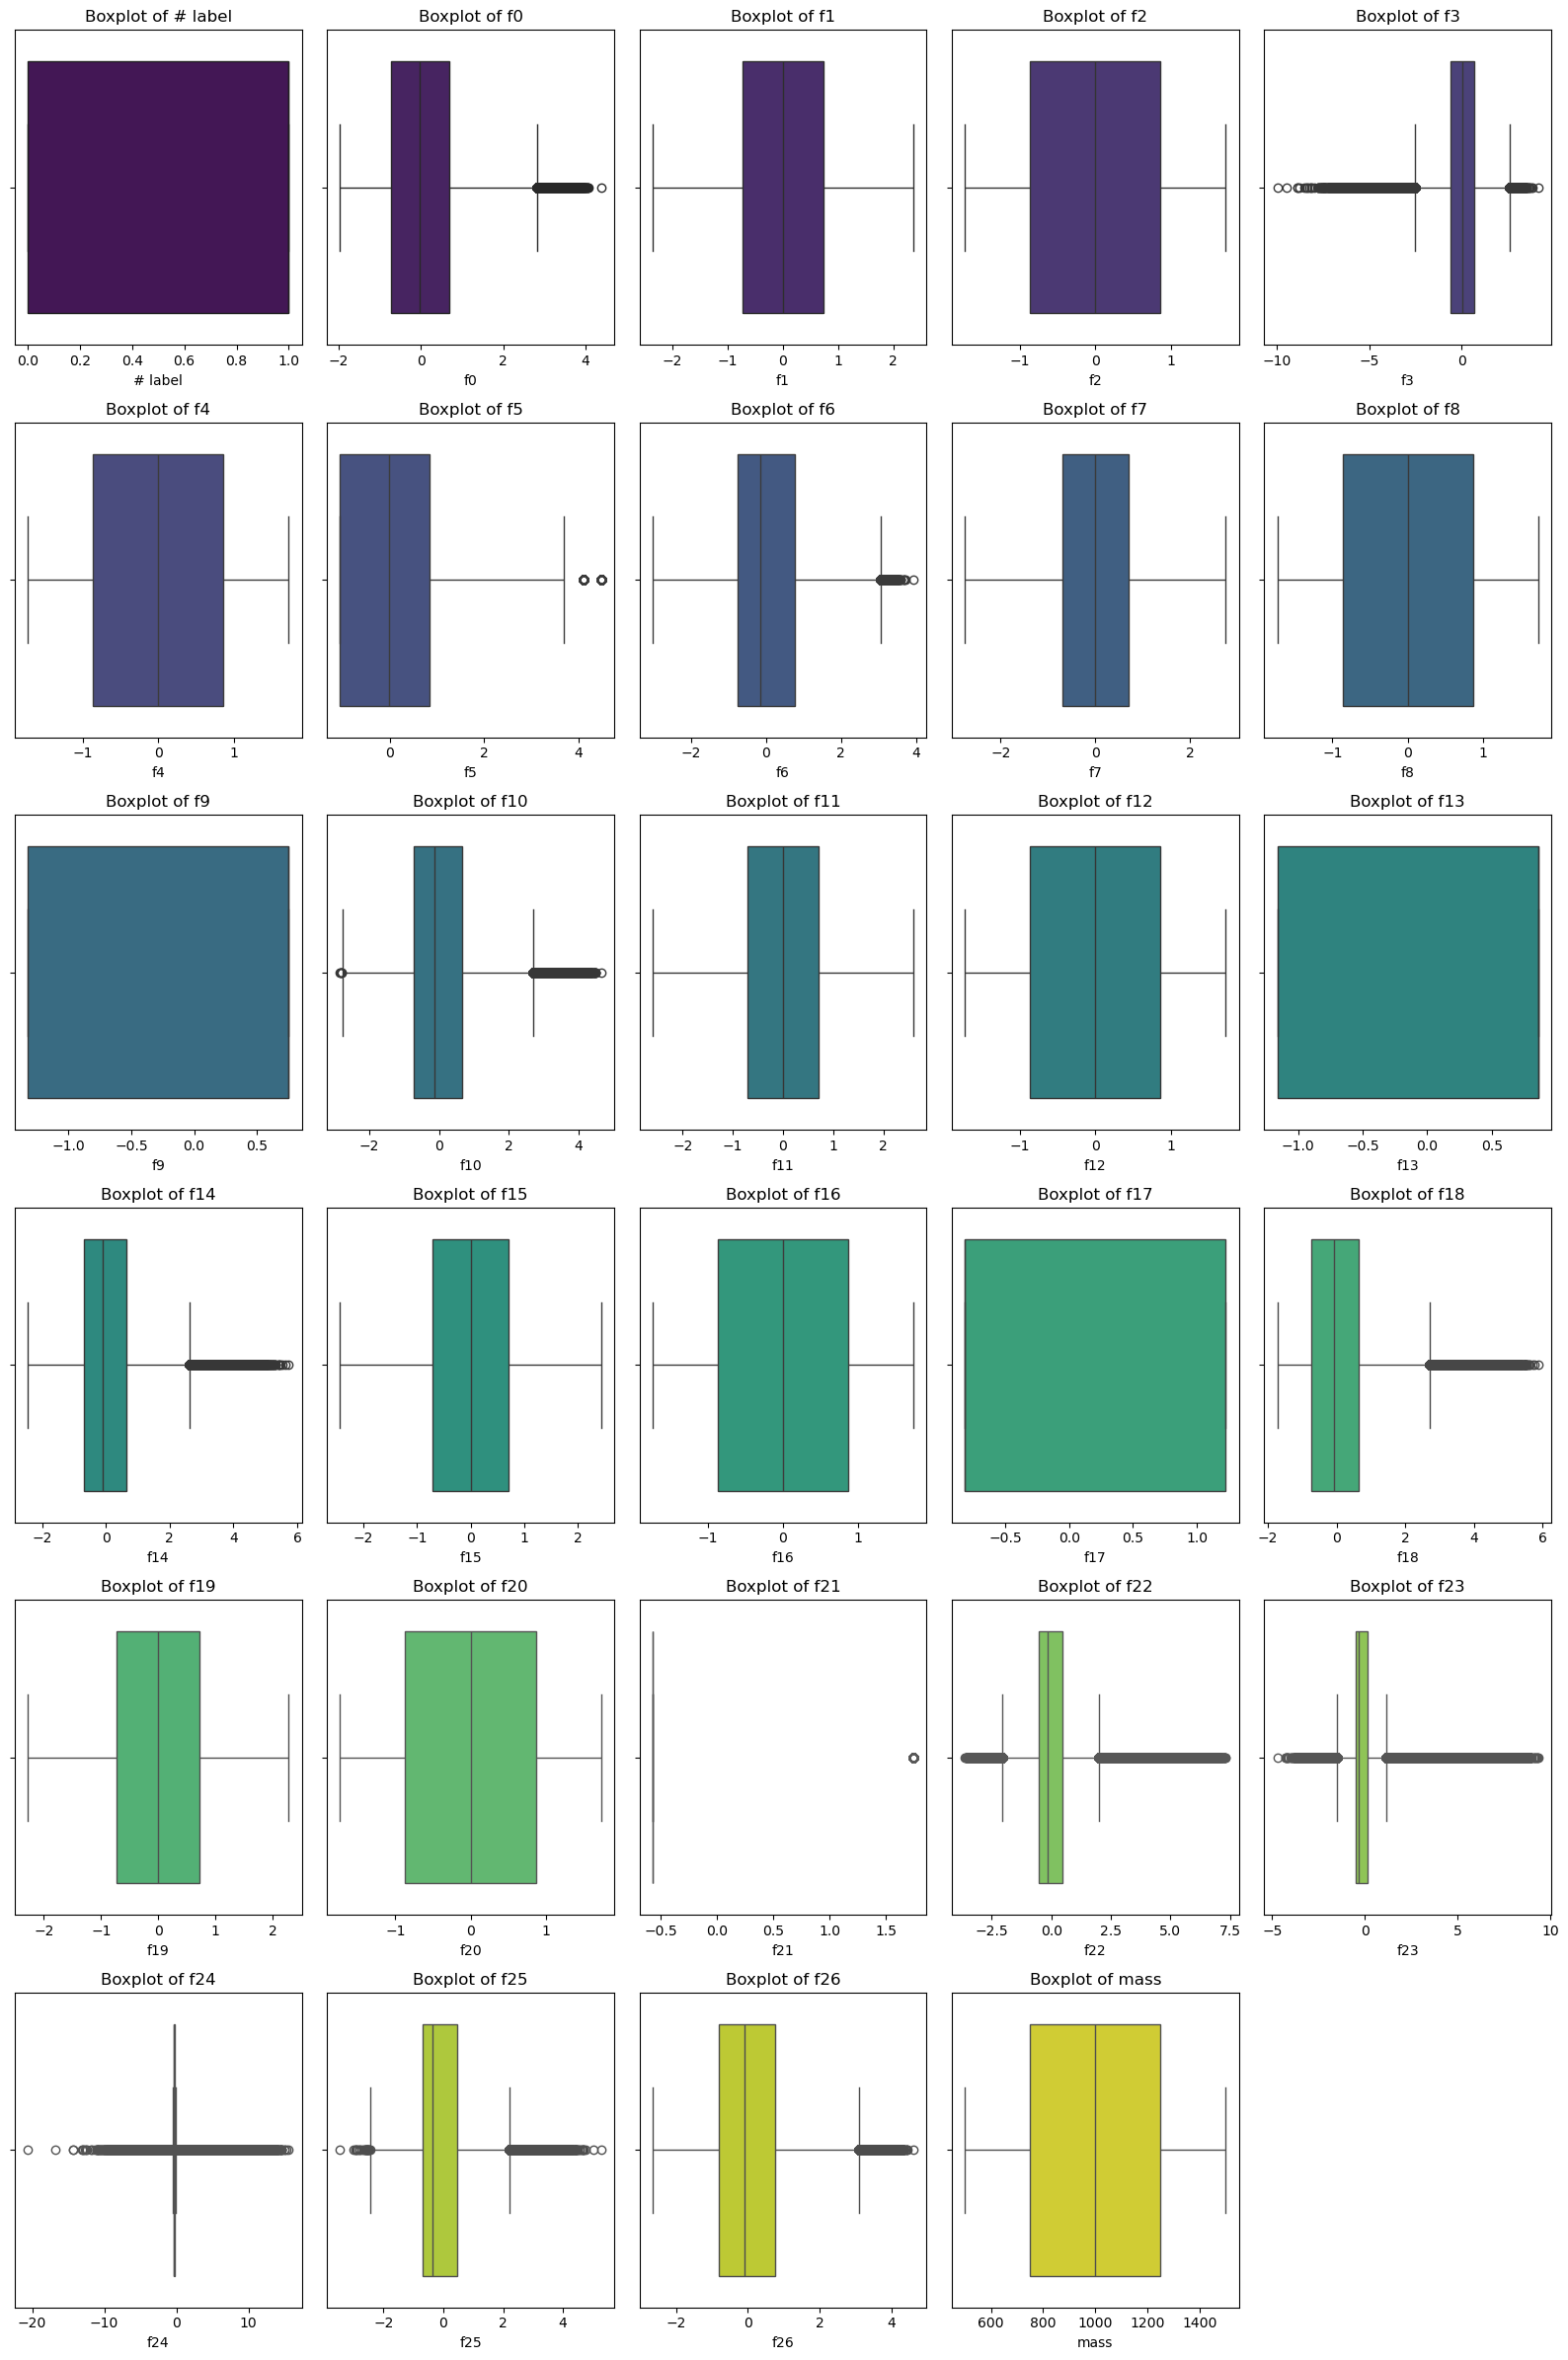

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of columns and setting up rows and columns for subplots
cols_per_row = 5
num_cols = len(all_data.columns)
rows = int(np.ceil(num_cols / cols_per_row))

# Create subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows))
axes = axes.flatten()

# Choose a color palette
palette = sns.color_palette("viridis", num_cols)

for i, column in enumerate(all_data.columns):
    sns.boxplot(x=all_data[column].to_pandas(), ax=axes[i], color=palette[i % len(palette)])
    axes[i].set_title(f'Boxplot of {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
